<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/RNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip /content/data.zip

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data.dataloader import DataLoader
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Preprocessing the Data

In [ ]:
import glob
import os
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string


### getting all the language path

In [ ]:
def findFiles(path): 
  return glob.glob(path)

In [ ]:
findFiles('data/names/*.txt')

['data/names/Greek.txt',
 'data/names/Polish.txt',
 'data/names/English.txt',
 'data/names/Arabic.txt',
 'data/names/Korean.txt',
 'data/names/Spanish.txt',
 'data/names/German.txt',
 'data/names/Portuguese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Irish.txt',
 'data/names/Russian.txt',
 'data/names/French.txt',
 'data/names/Dutch.txt',
 'data/names/Czech.txt',
 'data/names/Italian.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt',
 'data/names/Scottish.txt']

### Unicode to Ascii

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )



In [ ]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


### Language - name Dictionary

In [ ]:
language_words = {}
all_languages = []

def readwords(filename):
    words = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(name) for name in words]

for filename in findFiles('/content/data/names/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    all_languages.append(language)
    words = readwords(filename)
    language_words[language] = words

n_languages = len(all_languages)

In [ ]:
print(language_words['German'][:10])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer']


### Converting words to Tensor

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a name into a <name_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def wordToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(wordToTensor('Jones').size())

torch.Size([5, 1, 57])


### Splitting the DATA

image.png

In [ ]:
language_words_train = {}
language_words_val   = {}
language_words_test  = {}

for languages in all_languages:

  random.shuffle(language_words[languages])

  # Calculate the sizes of each name list 
  total_size = len(language_words[languages])
  a_size = int(total_size * 0.8)
  b_size = int(total_size * 0.1)
  c_size = total_size - a_size - b_size

  language_words_train[languages] = language_words[languages][:a_size]
  language_words_val[languages] = language_words[languages][a_size:a_size+b_size]
  language_words_test[languages] = language_words[languages][a_size+b_size:]

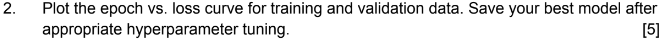

# RNN MODEL

### Hyperparameters

In [ ]:
input_size = 57
hidden_size = 256
output_size = 18
learning_rate = 0.004

n_epoch = 10


In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


rnn = RNN().to(device)

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    language = randomChoice(all_languages)
    word = randomChoice(language_words_train[language])
    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    word_tensor = wordToTensor(word)
    return language_tensor, word_tensor


In [ ]:


# Keep track of losses for plotting
current_loss = 0
loss_list = []
loss_list_val = []
epoch = 0

for iter in range(0, n_epoch * 16000):

    label_tensor, word_tensor = randomTrainingExample()

    hidden = rnn.initHidden()

    label_tensor, word_tensor, hidden = label_tensor.to(device), word_tensor.to(device), hidden.to(device)
    rnn.zero_grad()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    loss =  loss.item()
    current_loss += loss

    if iter %  16000 == 15999:    
        print(f'[epoch : {epoch + 1}] training loss: {current_loss / 8000:.3f}')
        epoch  += 1
        
        loss_list.append(current_loss / 8000)
        current_loss = 0.0

        val_loss_list = []
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for lang in all_languages:
                for word in language_words_val[lang]:
                    label_tensor = torch.tensor([all_languages.index(lang)], dtype=torch.long, device=device)
                    word_tensor = wordToTensor(word).to(device)

                    hidden = rnn.initHidden()

                    label_tensor, word_tensor, hidden = label_tensor.to(device), word_tensor.to(device), hidden.to(device)
                    for i in range(word_tensor.size()[0]):
                        output, hidden = rnn(word_tensor[i], hidden)

                    val_loss = criterion(output, label_tensor)
                    val_loss_list.append(val_loss.item())

                    _, predicted = torch.max(output, 1)

                    if predicted == label_tensor:
                        val_correct += 1
                    total_val += 1

            avg_val_loss = sum(val_loss_list) / len(val_loss_list)
            loss_list_val.append(avg_val_loss)
            val_accuracy = val_correct * 100 / total_val
            # accuracy_list_val.append(val_accuracy)
            print(f'Validation loss: {avg_val_loss:.3f}, Validation accuracy: {val_accuracy:.3f} %')
            print('--------------------------------------------')

[epoch : 0] training loss: 5.597
Validation loss: 2.501, Validation accuracy: 46.096 %
[epoch : 1] training loss: 4.880
Validation loss: 2.390, Validation accuracy: 36.737 %
[epoch : 2] training loss: 4.390
Validation loss: 2.137, Validation accuracy: 38.539 %
[epoch : 3] training loss: 3.983
Validation loss: 2.034, Validation accuracy: 34.735 %
[epoch : 4] training loss: 3.706
Validation loss: 2.035, Validation accuracy: 35.786 %
[epoch : 5] training loss: 3.480
Validation loss: 1.854, Validation accuracy: 40.941 %
[epoch : 6] training loss: 3.250
Validation loss: 1.642, Validation accuracy: 47.698 %
[epoch : 7] training loss: 3.096
Validation loss: 1.729, Validation accuracy: 43.994 %
[epoch : 8] training loss: 2.942
Validation loss: 1.557, Validation accuracy: 51.902 %
[epoch : 9] training loss: 2.818
Validation loss: 1.657, Validation accuracy: 47.447 %


# Loss Curves

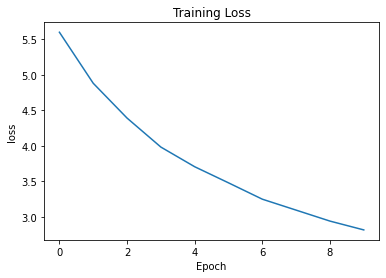

In [ ]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss')
plt.show()

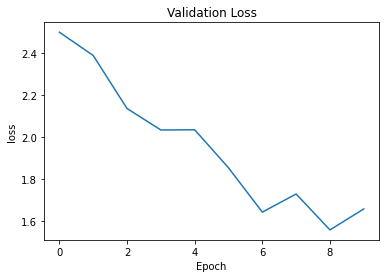

In [ ]:
x_values = range(len(loss_list_val)) 
plt.plot(x_values,loss_list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.show()

In [ ]:
torch.save(rnn.state_dict(), 'model.pt')

image.png

# Confusion Matrix on Validation data

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for lang in all_languages:
        for word in language_words_val[lang]:
            label_tensor = torch.tensor([all_languages.index(lang)], dtype=torch.long, device=device)
            word_tensor = wordToTensor(word).to(device)

            hidden = rnn.initHidden()

            label_tensor, word_tensor, hidden = label_tensor.to(device), word_tensor.to(device), hidden.to(device)
            for i in range(word_tensor.size()[0]):
                output, hidden = rnn(word_tensor[i], hidden)

            _, predicted = torch.max(output, 1)

            true_labels.append(label_tensor.item())
            predicted_labels.append(predicted.item())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(true_labels,predicted_labels))

print('-------------------------------------\n\n')

print(classification_report(true_labels,predicted_labels))

[[ 14   1   0   0   1   0   0   0   0   0   1   2   0   0   0   1   0   0]
 [  0   7   0   0   0   1   0   0   0   0   0   0   1   4   0   0   0   0]
 [  6  18  33  29   8   8  21  19  11  24   7  61  35  21   1   6   5  53]
 [  3   3   0 150   2   1   2   4   3   3   0   0   2   7   0  15   1   4]
 [  0   0   0   0   2   0   0   1   3   0   0   0   0   0   0   0   3   0]
 [  1   0   0   1   1   6   0   8   0   3   0   2   1   0   4   1   1   0]
 [  0   2   1   5   2   3  25   1   2   2   0   3  12   1   0   2   5   6]
 [  0   0   1   0   0   2   0   1   0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   2   0   0   0   0   0   0   0   2   0]
 [  0   0   0   2   1   1   0   1   1  10   0   2   2   0   1   1   0   1]
 [ 13  59   5  59   3  10  20  17   8  27 543  32  24  38  12  22   6  42]
 [  2   1   0   5   1   0   2   3   0   2   0   7   1   0   0   1   0   2]
 [  1   1   2   4   0   0   2   1   0   0   2   4   9   2   1   0   0   0]
 [  1  10   1   2   2   2

<AxesSubplot:>

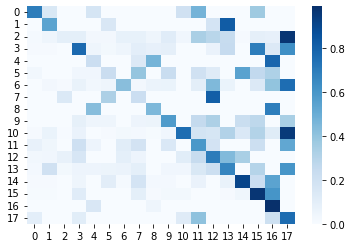

In [ ]:
import seaborn as sns

cf_matrix = confusion_matrix(true_labels,predicted_labels)
cf_matrix = cf_matrix.astype(np.float32)

# Normalising the matrix
for i in range(18):
    for j in range(18):
        cf_matrix[i][j] = cf_matrix[i][j] / cf_matrix[i].sum()

        
sns.heatmap(cf_matrix, cmap='Blues')



---



---

